In [275]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import textwrap

In [276]:
ticker = 'V'
START_DATE = '2020-06-30'
END_DATE = '2023-03-31'

In [277]:
x = yf.download(ticker, start=START_DATE, end=END_DATE)
x

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-30,191.490005,193.750000,190.160004,193.169998,189.604019,9040100
2020-07-01,193.850006,195.350006,192.660004,193.779999,190.202759,6394100
2020-07-02,196.000000,197.919998,195.000000,195.669998,192.057877,6299300
2020-07-06,198.729996,199.179993,195.679993,197.759995,194.109283,7292200
2020-07-07,196.809998,198.899994,193.809998,194.199997,190.614990,7660100
...,...,...,...,...,...,...
2023-03-24,220.669998,221.330002,218.250000,221.039993,221.039993,4792400
2023-03-27,222.589996,224.080002,221.389999,221.809998,221.809998,7210900
2023-03-28,222.820007,223.330002,218.649994,220.330002,220.330002,6418400


In [278]:
adj_close = x['Adj Close']
returns = adj_close.pct_change().dropna()
returns

Date
2020-07-01    0.003158
2020-07-02    0.009753
2020-07-06    0.010681
2020-07-07   -0.018002
2020-07-08    0.004480
                ...   
2023-03-24   -0.006963
2023-03-27    0.003484
2023-03-28   -0.006672
2023-03-29    0.013480
2023-03-30   -0.004210
Name: Adj Close, Length: 692, dtype: float64

In [279]:
train = returns['2020-06-30':'2022-08-31']
test = returns['2022-09-01':'2023-03-31']

In [280]:
train

Date
2020-07-01    0.003158
2020-07-02    0.009753
2020-07-06    0.010681
2020-07-07   -0.018002
2020-07-08    0.004480
                ...   
2022-08-25    0.015242
2022-08-26   -0.033028
2022-08-29   -0.002760
2022-08-30   -0.004695
2022-08-31   -0.013259
Name: Adj Close, Length: 547, dtype: float64

In [281]:
test

Date
2022-09-01    0.007146
2022-09-02   -0.011842
2022-09-06    0.004450
2022-09-07    0.008961
2022-09-08    0.001447
                ...   
2023-03-24   -0.006963
2023-03-27    0.003484
2023-03-28   -0.006672
2023-03-29    0.013480
2023-03-30   -0.004210
Name: Adj Close, Length: 145, dtype: float64

In [282]:
T = len(test)
N = len(test)
S_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

In [283]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N):
   dt = T/N
   dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
   W = np.cumsum(dW, axis=1)
   time_step = np.linspace(dt, T, N)
   time_steps = np.broadcast_to(time_step, (n_sims, N))
   S_t = (
      s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * W)
   )
   S_t = np.insert(S_t, 0, s_0, axis=1)
   return S_t

In [284]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
gbm_simulations

array([[197.87927246, 195.45547203, 198.42294371, ..., 220.114883  ,
        223.61367235, 225.48723792],
       [197.87927246, 200.99043566, 198.98867452, ..., 160.42322425,
        161.11330726, 158.00381446],
       [197.87927246, 198.29129413, 193.10348797, ..., 254.71790143,
        254.85256556, 255.07137366],
       ...,
       [197.87927246, 196.75673769, 196.16486635, ..., 247.59384511,
        245.78979399, 237.11494438],
       [197.87927246, 200.624485  , 201.99051535, ..., 218.60983558,
        218.48613953, 221.31467074],
       [197.87927246, 199.26328766, 202.38547307, ..., 142.13073851,
        142.37691889, 143.50989172]])

In [285]:
# prepare objects for plotting
LAST_TRAIN_DATE = train.index[-1].date()
FIRST_TEST_DATE = test.index[0].date()
LAST_TEST_DATE = test.index[-1].date()
PLOT_TITLE = (f'{ticker} Simulation 'f'({FIRST_TEST_DATE}:{LAST_TEST_DATE})')

In [286]:
selected_indices = adj_close[LAST_TRAIN_DATE:LAST_TEST_DATE].index
index = [date.date() for date in selected_indices]

In [287]:
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), index=index)
gbm_simulations_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2022-08-31,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272,...,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272,197.879272
2022-09-01,195.455472,200.990436,198.291294,197.417470,196.533326,204.224275,203.244607,195.110335,206.092894,197.437670,...,200.473693,194.586099,196.118591,201.637707,201.943163,197.853783,200.540239,196.756738,200.624485,199.263288
2022-09-02,198.422944,198.988675,193.103488,192.767353,198.033101,200.080342,201.676732,194.363949,207.667338,198.621582,...,199.549723,195.268086,200.314101,203.712793,207.324485,194.755736,201.328748,196.164866,201.990515,202.385473
2022-09-06,193.671072,198.644116,189.065176,194.941090,203.637298,196.552296,200.980058,193.943980,206.250553,201.779513,...,199.738694,195.169900,203.988667,206.919896,203.455234,195.354601,209.401983,198.690011,195.361187,201.051331
2022-09-07,197.594683,200.047313,186.928976,197.431258,203.735069,198.713890,198.770202,193.822724,210.184729,204.651791,...,199.619055,195.464474,203.808046,207.881403,198.867546,194.457906,210.798357,200.167339,191.726105,197.830726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-24,215.086428,163.355511,251.027529,174.363064,231.417032,226.118436,272.472231,178.227515,190.384807,237.589436,...,214.350857,297.957526,183.470587,250.539931,164.813460,194.168403,219.375652,256.369962,222.612358,148.086846
2023-03-27,216.111083,164.541619,257.252463,172.721071,223.599073,232.346366,272.192896,173.951804,187.029975,245.605388,...,213.698146,301.601817,186.791869,251.696314,164.365463,193.483331,212.391053,249.211763,220.039899,144.669943
2023-03-28,220.114883,160.423224,254.717901,174.203327,219.133993,240.002485,276.604670,170.735014,191.036789,243.530851,...,216.430351,295.415390,188.030995,252.705707,159.331588,191.186909,214.104120,247.593845,218.609836,142.130739
2023-03-29,223.613672,161.113307,254.852566,173.434956,215.110030,241.579227,274.831413,165.505130,189.075250,244.866721,...,214.675315,296.345486,184.463985,256.462136,161.821197,190.509924,213.626280,245.789794,218.486140,142.376919


In [288]:
V1_sim_mean = gbm_simulations_df.iloc[-1,0:].mean()
V1_sim_mean

211.70668270129696

In [289]:
V1_visa = adj_close.iloc[-1]
V1_visa

222.36000061035156

In [290]:
#Discount or premium % = ((Actual Price - Simulated Price) / Actual Price) * 100
percent_discount_or_premium = ((V1_visa-V1_sim_mean)/V1_visa) * 100

if percent_discount_or_premium > 0:
    discount_or_premium = "premium"
else:
    discount_or_premium = "discount"

validation = (f'Based on the mean price, {V1_sim_mean.round(4)}, from 100 simulated price paths and its actual price, {V1_visa.round(4)}, AXP was trading at a {percent_discount_or_premium.round(4)}% {discount_or_premium} as of {END_DATE}')
print(validation)

Based on the mean price, 211.7067, from 100 simulated price paths and its actual price, 222.36, AXP was trading at a 4.791% premium as of 2023-03-31


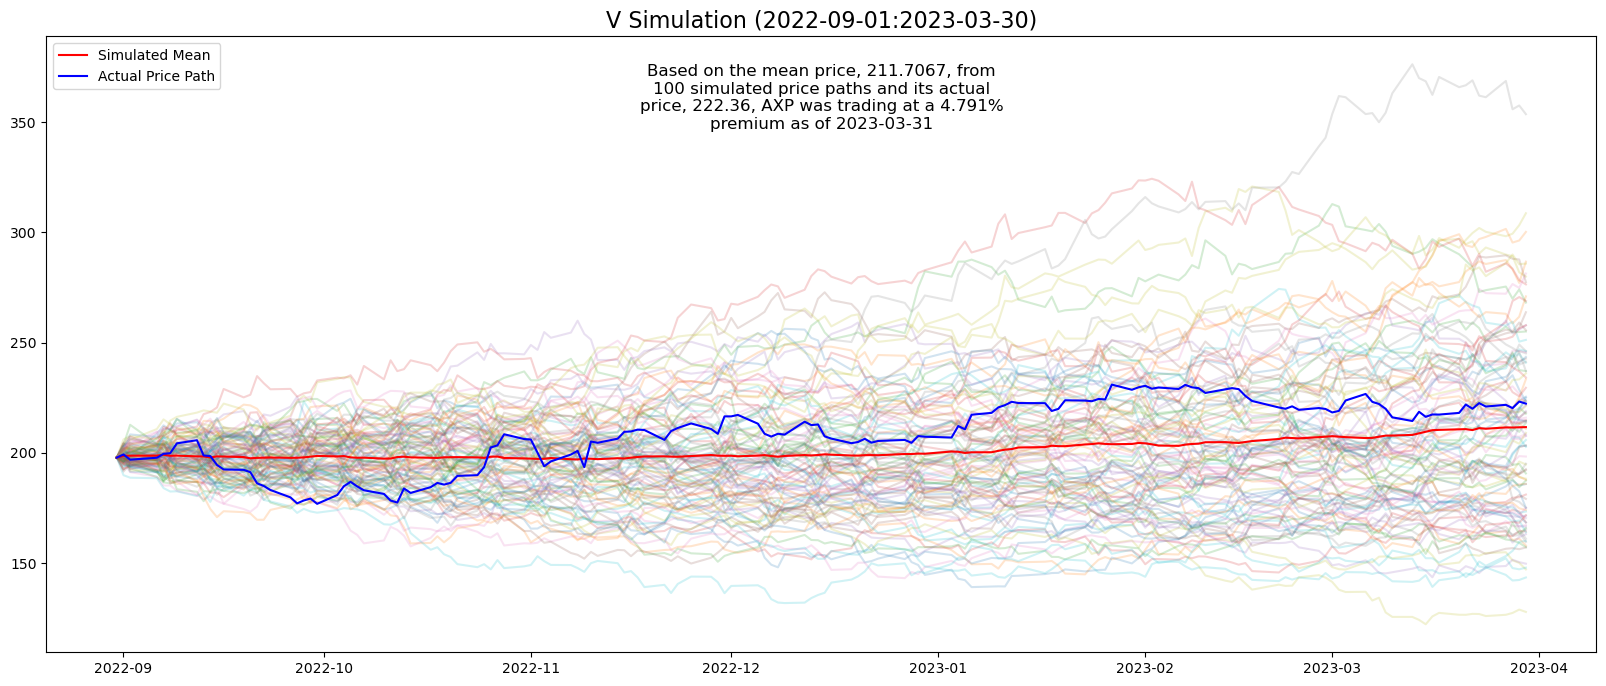

In [291]:
# plotting
ax = gbm_simulations_df.plot(figsize=(20, 8),alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), color='red')
line_2, = ax.plot(index, adj_close[LAST_TRAIN_DATE:LAST_TEST_DATE], color='blue')
ax.set_title(PLOT_TITLE, fontsize=16)
ax.legend((line_1, line_2), ('Simulated Mean', 'Actual Price Path'))
ax.text(0.5,
         0.90,
         textwrap.fill(validation, 42),
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax.transAxes,
         fontsize=12)
plt.show()